In [703]:
# Chem 277B: Machine Learning Algorithms for
#            Molecular Sciences
#
# Date Created: 12/07/2024
# Last revisited: 12/13/2024


##################################
# FILE FOR RUNNING LSTM MODEL
##################################

'''this notebook is running an example cnn + stacked lstm:

first it will
classify a given state of the reactor based on past data

then...

it will
predicted future parameter values based on the past data

'''


'this notebook is running an example cnn + stacked lstm:\n\nfirst it will\nclassify a given state of the reactor based on past data\n\nthen...\n\nit will\npredicted future parameter values based on the past data\n\n'

In [704]:
# imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nrsim_lstm import NRSIM_LSTM as lstm
import Archive.utils277b as utils
import random


random.seed(42)




filepaths = {"Simulation Data/Sim_only_large_injection_of_air": "Large Injection of Air",
             "Simulation Data/Sim_No_Casualties": "No Casualties",
             "Simulation Data/Sim_only_large_fuel_element_failure": "Large Fuel Element Failure",
             "Simulation Data/Sim_only_large_resin_overheat": "Large Resin Overheat",
             "Simulation Data/Sim_only_small_fuel_element_failure": "Small Fuel Element Failure",
             "Simulation Data/Sim_only_small_injection_of_air": "Small Injection of Air",
             "Simulation Data/Sim_only_small_resin_overheat": "Small Resin Overheat"}



In [705]:
# getting data


filepath="Simulation Data/Sim_only_small_injection_of_air"
data = pd.read_csv(filepath)


In [706]:
data.head()

,Time,pH,Hydrogen,Total Gas,Temperature,Pressure,Radioactivity,Power,Reactor Safety,Injection of Air,Injection of Air Degree,Resin Overheat,Resin Overheat Degree,Fuel Element Failure,Fuel Element Failure Degree,Chemical Addition,Vent Gas
0,0,11.000,50.000000,60.000000,500.000000,2100.000000,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,1,10.998,50.112998,60.112998,500.732703,2104.971916,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,2,10.996,50.225941,60.225941,501.463398,2109.930204,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,3,10.994,50.338517,60.338517,502.190083,2114.861274,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
4,4,10.992,50.450414,60.450414,502.910764,2119.751611,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [707]:

# Organizing the dataframe


numerical = ['Time', 'pH', 'Hydrogen', 'Total Gas', 'Temperature', 'Pressure','Radioactivity', 'Power']
categorical = ['Reactor Safety', 'Injection of Air', 'Injection of Air Degree', 
               'Resin Overheat', 'Resin Overheat Degree', 'Fuel Element Failure', 
               'Fuel Element Failure Degree', 'Chemical Addition', 'Vent Gas']


# In case there are NaN values
data = data.fillna(False)
data[categorical] = data[categorical].astype(int)


# making sure NaN values are filled
unique_values = data.apply(pd.Series.unique)
print(unique_values)


Time                           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
pH                             [11.0, 10.998, 10.996, 10.993999999999998, 10....
Hydrogen                       [50.0, 50.11299808734272, 50.22594112618216, 5...
Total Gas                      [60.0, 60.11299808734272, 60.22594112618216, 6...
Temperature                    [500.0, 500.7327033874012, 501.4633984857471, ...
Pressure                       [2100.0, 2104.97191584308, 2109.930204010427, ...
Radioactivity                                                             [10.0]
Power                                                                    [100.0]
Reactor Safety                                                            [0, 1]
Injection of Air                                                          [0, 1]
Injection of Air Degree                                                   [0, 1]
Resin Overheat                                                               [0]
Resin Overheat Degree       

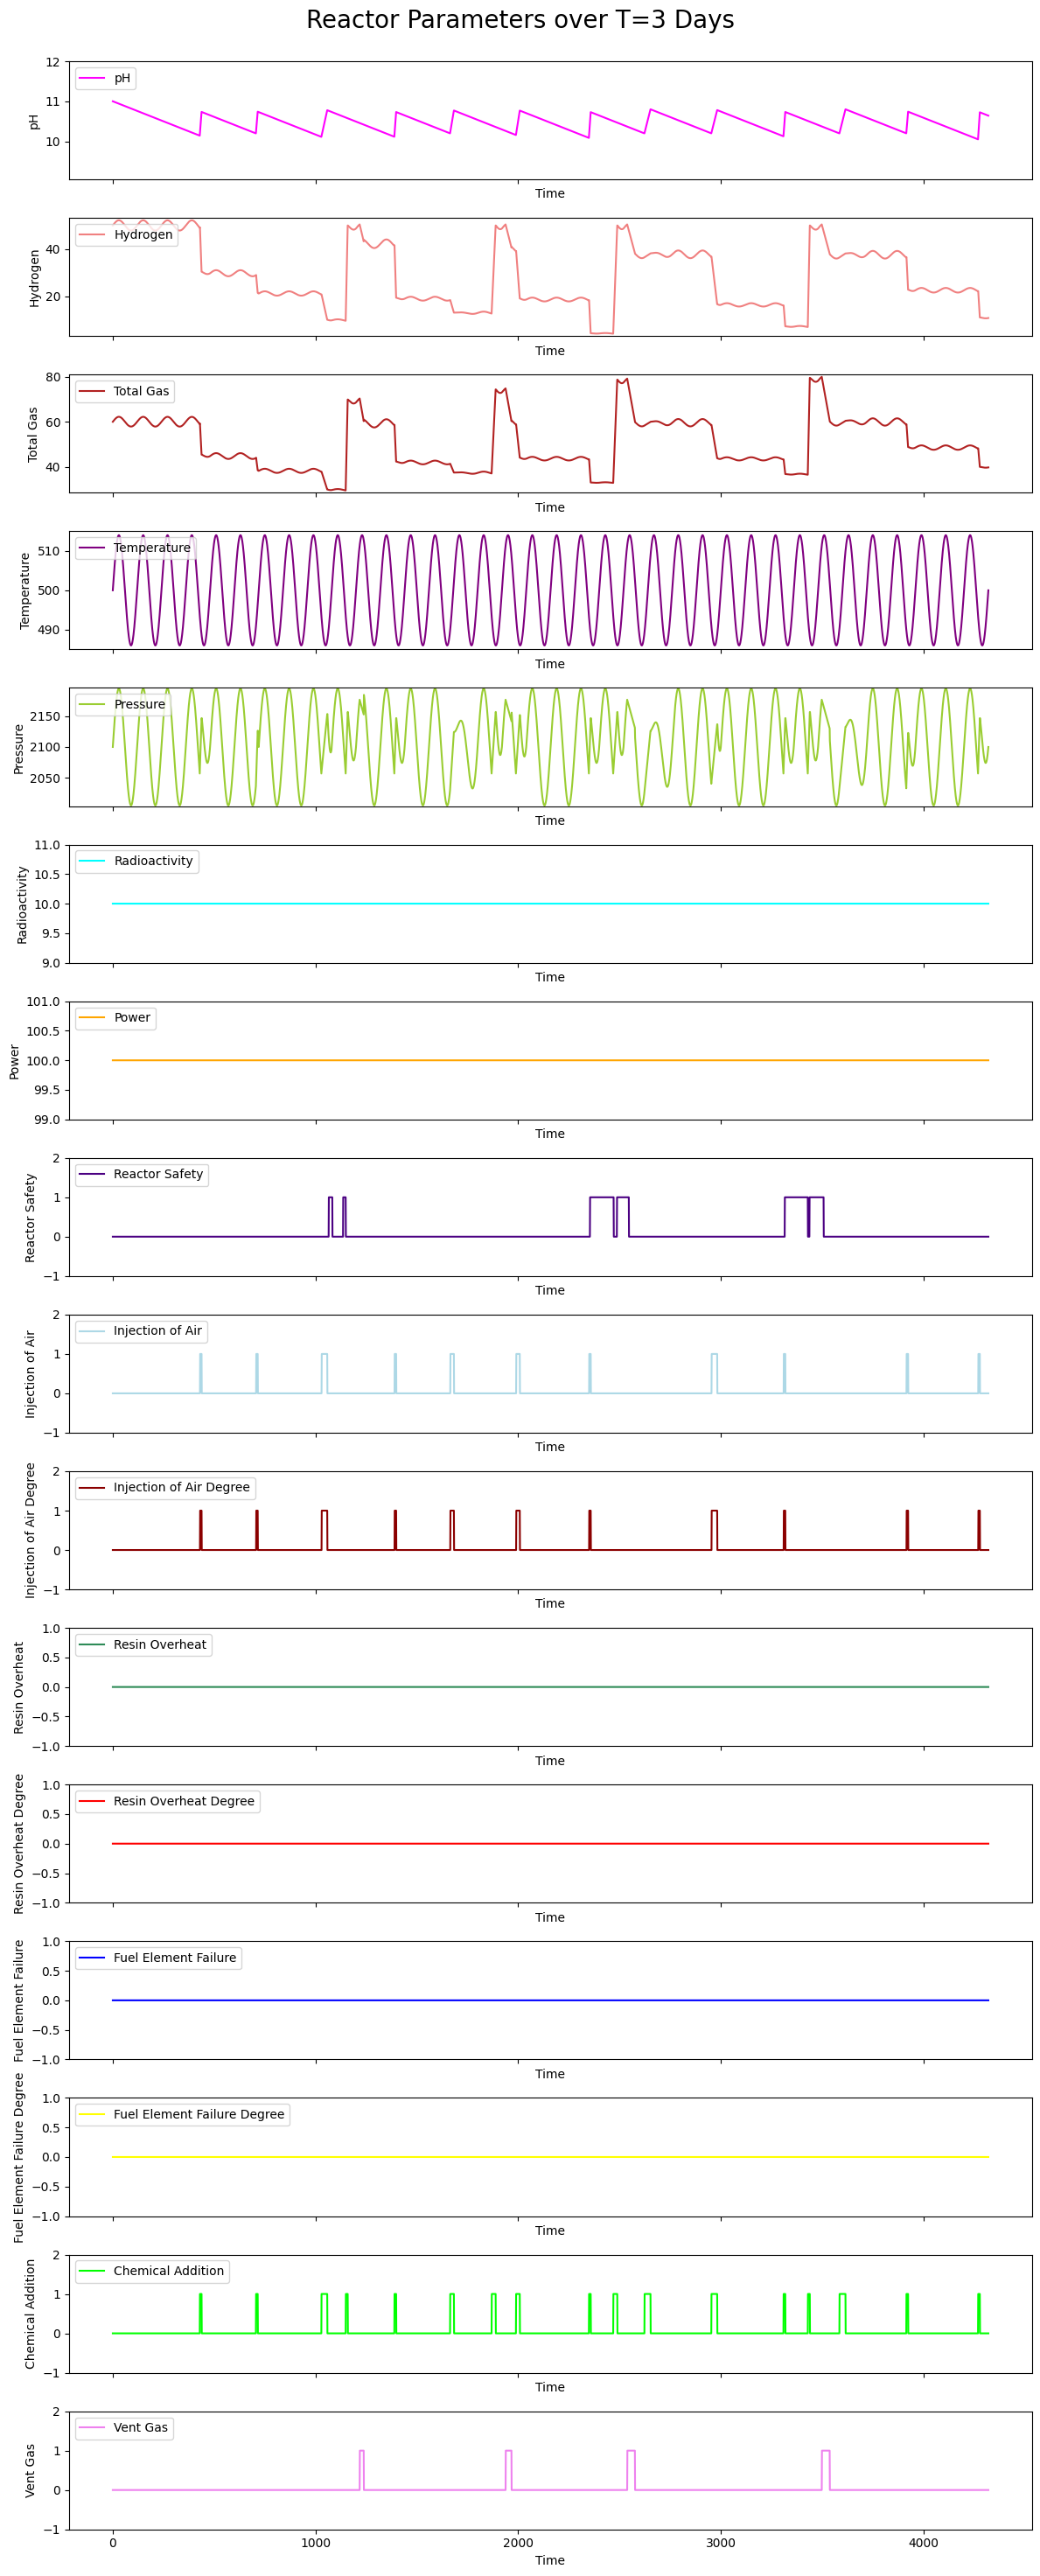

In [708]:
# looking at data 

datamT = data.drop(columns=["Time"])
color = ["magenta", "lightcoral", "firebrick", 
         "purple", "yellowgreen", "cyan",
         "orange", "indigo", "lightblue",
         "darkred", "seagreen", "red", "blue", "yellow", 
         "lime", "violet"]
fig, axes = plt.subplots(len(datamT.columns), 1, figsize=(12, 30), sharex=True)
fig.suptitle("Reactor Parameters over T=3 Days", fontsize=20)
for i, feature in enumerate(datamT.columns):
    axes[i].plot(datamT.index, datamT[feature], label=feature, color=color[i])
    axes[i].set_ylabel(feature)
    axes[i].legend(loc='upper left')
    axes[i].set_ylim(datamT[feature].min() - 1, datamT[feature].max() + 1)
    axes[i].set_xlabel("Time")
plt.tight_layout()
plt.subplots_adjust(top=0.96)




In [709]:
# FOR CLASSIFICATION (Predicting the Reactor State)


''' 
Note:

each simulation is a sample time series 
you have different time series data for the training
e.g. if you ran the simulation for 50 time steps 100 times
you would have 100 samples of size 50 and could use the outputted
casualty values that occur at t=51 for each sample to train the model
in our case we are just
taking different time slices of our single simulation run for the samples
and each timeslice will be followed by a reactor state (0 or 1) for each 
categorical casualty feature in the next time step

once the training is complete you could just feed in a single run of the simulation
parameters over t (in this case 50) amount of timesteps before the instance you want to make a 
prediction:
Xrun with dim: (1 sample, npast timesteps (50), nfeatures (nparameters using for prediciton)) -> 
Ypred vector output of
[1, 0, 1, .........] aka (1 row x n casualty features) dimensional boolean vector
meaning...
[casualty 1 occuring: (0 = no, 1 = yes),  casualty 2 occuring: ..., .......]



so to recap...


ideally you want your training to look like this:

            X_train                                                         Y_train
Dimensions: (number of samples, timesteps in past, number of features) ---> (number of samples, number of features)

and testing to look like:

            X_test                                          Y_test
Dimensions: (1, timesteps in past, number of features) ---> (1, number of features)

'''

' \nNote:\n\neach simulation is a sample time series \nyou have different time series data for the training\ne.g. if you ran the simulation for 50 time steps 100 times\nyou would have 100 samples of size 50 and could use the outputted\ncasualty values that occur at t=51 for each sample to train the model\nin our case we are just\ntaking different time slices of our single simulation run for the samples\nand each timeslice will be followed by a reactor state (0 or 1) for each \ncategorical casualty feature in the next time step\n\nonce the training is complete you could just feed in a single run of the simulation\nparameters over t (in this case 50) amount of timesteps before the instance you want to make a \nprediction:\nXrun with dim: (1 sample, npast timesteps (50), nfeatures (nparameters using for prediciton)) -> \nYpred vector output of\n[1, 0, 1, .........] aka (1 row x n casualty features) dimensional boolean vector\nmeaning...\n[casualty 1 occuring: (0 = no, 1 = yes),  casualty 

In [710]:
# setting up training data 
# lets say we want to use 50 timesteps of past data
# when we go to predict the reactor state
npast_timesteps = 50

# since we want to
# classify the reactor conditions
# we only need
# the next timestep
nfuture_timesteps = 1

# we want to use the features from the past 
# this number can be whatever so if you only want to use two
# features (e.g. temp, pressure) for your prediction
# you would set it to two
# here it is set up with every numerical feature (see above)
nfeatures_past = len(numerical) - 1

# again we are predicting the reactor state
# so we want to return an array of (0,1) corresponding to whether
# or not each condition is occuring
# e.g. if there is a fuel element failure or chemical addition
# and ideally the degree of each
npredfeatures = len(categorical)


In [711]:
# initializing training matricies
X = np.array(data[numerical].drop(columns=["Time"]))
Y = np.array(data[categorical])

print(X.shape, Y.shape)

(4321, 7) (4321, 9)


In [712]:
# scaling and preprocessing data for training


scalerY, Y_norm = utils.scale(Y)
scalerX, X_norm = utils.scale(X)

[X, _] = utils.prep_lstm_data(X_norm, npast_timesteps, nfuture_timesteps)
[_, Y] = utils.prep_lstm_data(Y_norm, npast_timesteps, nfuture_timesteps)



In [713]:
''' notice how 

the number of rows in each matrix is now: 
len(time series) - # past time steps - # future time steps + 1 
(there are now 4271 different time series slices from our original sim run
incrementing in a single time step)

the number of columns in X is:
# past timesteps per slice (50)

the number of columns in Y is:
one timestep per past time slice (because outputting the reactor states at current time)

the depth of X is:
# of features used to predict output (7 numerical features pH, pressure, temp, etc.)

The depth of Y is:
# of features being predicted (in our case parameters that describe the reactor state)
'''
print(X.shape, Y.shape)

(4271, 50, 7) (4271, 1, 9)


In [714]:
# train test split (theoretically you could test a single data series from a new sim run)

cut = int(np.round(0.7*Y.shape[0]))

TrainX, TrainY = X[:cut], Y[:cut]
TestX, TestY = X[cut:], Y[cut:]


In [715]:
# setting up actual model (for classification)


classification=True


# because we are using a CNN layer this 
# input reshape must be performed

TrainXreshape = TrainX.reshape((TrainX.shape[0], 1, TrainX.shape[1], TrainX.shape[2]))



# stacked lstm layers
neurons = [32, 32]
activation = "tanh"

# temporal params
n_past_timesteps = TrainX.shape[1]
n_features = TrainX.shape[2]
n_predicted_timesteps = TrainY.shape[1]
n_predicted_features = TrainY.shape[2]

# optimization + metrics
optimizer = "adam"
loss = "binary_crossentropy"
metrics =["accuracy"]

# convolutional layer
conv_layer = True
nfilters = 64  
conv_act = "relu" 
pool_size = 2  

# dropout
dropout = 0.2



my_model = lstm(
    neurons,
    activation,
    n_past_timesteps,
    n_features,
    n_predicted_timesteps,
    n_predicted_features,
    optimizer,
    loss,
    metrics,
    dropout,
    conv_layer,
    nfilters,
    conv_act,
    pool_size,
    classification
)


In [716]:
# fitting model on training data

n_epochs = 100
batch_size = 64


my_model.fit(TrainXreshape, TrainY, nEpochs=n_epochs, nBatches=batch_size, 
             val_split=0.2, verb=2, shuf=False)


Epoch 1/100


38/38 - 2s - 42ms/step - accuracy: 0.0234 - loss: 0.5556 - val_accuracy: 0.0502 - val_loss: 0.3886
Epoch 2/100
38/38 - 0s - 3ms/step - accuracy: 0.0640 - loss: 0.2675 - val_accuracy: 0.0502 - val_loss: 0.2166
Epoch 3/100
38/38 - 0s - 3ms/step - accuracy: 0.1564 - loss: 0.1533 - val_accuracy: 0.0502 - val_loss: 0.1835
Epoch 4/100
38/38 - 0s - 4ms/step - accuracy: 0.2705 - loss: 0.1224 - val_accuracy: 0.8244 - val_loss: 0.1772
Epoch 5/100
38/38 - 0s - 4ms/step - accuracy: 0.3499 - loss: 0.1120 - val_accuracy: 0.8244 - val_loss: 0.1758
Epoch 6/100
38/38 - 0s - 4ms/step - accuracy: 0.4084 - loss: 0.1065 - val_accuracy: 0.8244 - val_loss: 0.1755
Epoch 7/100
38/38 - 0s - 4ms/step - accuracy: 0.4339 - loss: 0.1039 - val_accuracy: 0.8244 - val_loss: 0.1754
Epoch 8/100
38/38 - 0s - 4ms/step - accuracy: 0.4699 - loss: 0.1012 - val_accuracy: 0.8244 - val_loss: 0.1753
Epoch 9/100
38/38 - 0s - 4ms/step - accuracy: 0.4645 - loss: 0.1019 - val_accuracy: 0.8244 - val_loss: 0.1753
Epoch 10/100
38/38 - 

In [717]:
# model history

out = my_model.get_model().history


In [718]:
out.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

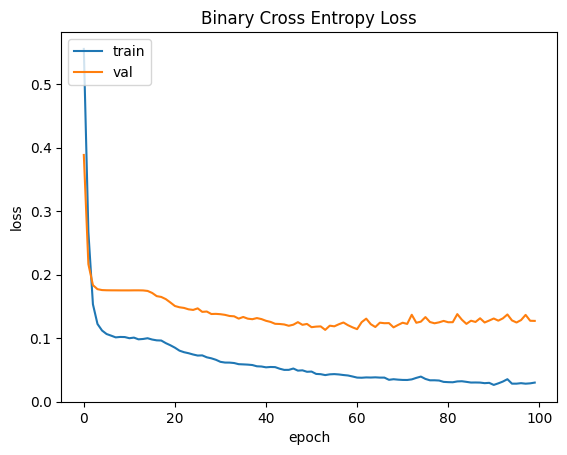

In [719]:
# plotting loss during training
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('Binary Cross Entropy Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()


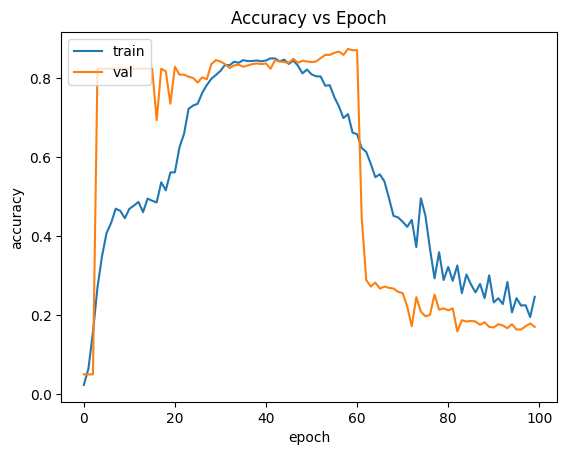

In [720]:
# plotting accuracy during training
plt.plot(out.history['accuracy'])
plt.plot(out.history['val_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [721]:
# reshaping for testing data 
TestXreshape = TestX.reshape((TestX.shape[0], 1, TestX.shape[1], TestX.shape[2]))

In [722]:
# predicting outputs for test data
Y_pred_normalized = my_model.predict(TestXreshape)

# applying a threshold since the model outputs binary class probabilities
threshold = 0.5
Y_pred_normalized = (Y_pred_normalized >= threshold).astype(int)


# this step is not really necessary since all of the values should be 0 , 1 already, but will
# need this when predicting actual parameters
Y_pred_reshape = Y_pred_normalized.reshape(-1, npredfeatures)
Y_pred = scalerY.inverse_transform(Y_pred_reshape)

Y_pred = Y_pred.reshape(Y_pred_normalized.shape)



41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [723]:
# lets compare the reactor state at time t = 3502 to our prediction
# because of the train test split we only have predictions for the last 30% of 
# timesteps


data[categorical].iloc[3502]



Reactor Safety                 1
Injection of Air               0
Injection of Air Degree        0
Resin Overheat                 0
Resin Overheat Degree          0
Fuel Element Failure           0
Fuel Element Failure Degree    0
Chemical Addition              0
Vent Gas                       1
Name: 3502, dtype: int64

In [724]:
# to find index in our test vector we need to use following formula: 

'''timestep we want - number of timesteps in past - 1 (due to python indexing starting at 0)
 - 3025(this last number is bc of the train test split and the training size is 3025)'''
time_index = 3502 - 50 - 1 - 3025

# here we see the actual value matches
TestY[time_index]


array([[1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [725]:
# prediciton
Y_pred[time_index]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Above you can see the model's prediction for the reactor state at the specified time step

In [726]:
# PREDICTING FUTURE PARAMETER VALUES

'''


The idea is similar to 


classification however our Ypred will have an output of:

(series, ntimesteps future, n predicted features)

because instead of classifying the reactor state at a single given timestep we are trying
to predict future values for multiple timesteps based on our parameter values in the past
again the series can be equal to 1 if you want to only predict for one time series output 
the model is trained

also using mse instead of binary cross entropy since the parameters have 
numerical and not binary values'''


'\n\n\nThe idea is similar to \n\n\nclassification however our Ypred will have an output of:\n\n(series, ntimesteps future, n predicted features)\n\nbecause instead of classifying the reactor state at a single given timestep we are trying\nto predict future values for multiple timesteps based on our parameter values in the past\nagain the series can be equal to 1 if you want to only predict for one time series output \nthe model is trained\n\nalso using mse instead of binary cross entropy since the parameters have \nnumerical and not binary values'

In [727]:
# same as categorical
npast_timesteps = 50

# now predicting multiple timesteps in the future
nfuture_timesteps = 35

# predicting all of the numerical parameters from past data
nfeatures_past = len(numerical) - 1
npredfeatures = nfeatures_past

In [728]:
# again we want future predictions for EVERY feature based on past data of EVERY feature
# if we wanted to use some of the features in the past we would specify those in X
# and the future features we want to predict would be specified in Y
X = np.array(data[numerical].drop(columns=["Time"]))
Y = np.array(data[numerical].drop(columns=["Time"]))

print(X.shape, Y.shape)

(4321, 7) (4321, 7)


In [729]:
# scaling and preprocessing data for training


scalerY, Y_norm = utils.scale(Y)
scalerX, X_norm = utils.scale(X)

[X, _] = utils.prep_lstm_data(X_norm, npast_timesteps, nfuture_timesteps)
[_, Y] = utils.prep_lstm_data(Y_norm, npast_timesteps, nfuture_timesteps)



In [730]:
''' the number of columns in X is:
# past timesteps per slice (50)

the number of columns in Y is:
number of future timesteps per slice (35)

the depth of X is:
# of features used to predict output (7 numerical features pH, pressure, temp, etc.)

The depth of Y is:
# of features being predicted (7 same features in this case)

'''

print(X.shape, Y.shape)

(4237, 50, 7) (4237, 35, 7)


In [731]:
# train test split

cut = int(np.round(0.7*Y.shape[0]))

TrainX, TrainY = X[:cut], Y[:cut]
TestX, TestY = X[cut:], Y[cut:]


In [732]:
# setting up actual model (for parameter prediction)


classification=False


# because we are using a CNN layer this 
# input reshape must be performed

TrainXreshape = TrainX.reshape((TrainX.shape[0], 1, TrainX.shape[1], TrainX.shape[2]))



# stacked lstm layers
neurons = [64, 32]
activation = "tanh"

# temporal params
n_past_timesteps = TrainX.shape[1]
n_features = TrainX.shape[2]
n_predicted_timesteps = TrainY.shape[1]
n_predicted_features = TrainY.shape[2]

# optimization + metrics
optimizer = "adam"
loss = "mse"
metrics =["mse", "mae"]

# convolutional layer
conv_layer = True
nfilters = 64  
conv_act = "relu" 
pool_size = 2  

# dropout
dropout = 0.2



my_model = lstm(
    neurons,
    activation,
    n_past_timesteps,
    n_features,
    n_predicted_timesteps,
    n_predicted_features,
    optimizer,
    loss,
    metrics,
    dropout,
    conv_layer,
    nfilters,
    conv_act,
    pool_size,
    classification
)


In [733]:
# fitting model on training data

n_epochs = 100
batch_size = 64


my_model.fit(TrainXreshape, TrainY, nEpochs=n_epochs, nBatches=batch_size, 
             val_split=0.2, verb=2, shuf=False)


Epoch 1/100


38/38 - 1s - 39ms/step - loss: 0.1468 - mae: 0.2723 - mse: 0.1468 - val_loss: 0.0667 - val_mae: 0.1895 - val_mse: 0.0667
Epoch 2/100
38/38 - 0s - 4ms/step - loss: 0.0678 - mae: 0.1960 - mse: 0.0678 - val_loss: 0.0601 - val_mae: 0.1833 - val_mse: 0.0601
Epoch 3/100
38/38 - 0s - 4ms/step - loss: 0.0572 - mae: 0.1782 - mse: 0.0572 - val_loss: 0.0503 - val_mae: 0.1667 - val_mse: 0.0503
Epoch 4/100
38/38 - 0s - 5ms/step - loss: 0.0504 - mae: 0.1638 - mse: 0.0504 - val_loss: 0.0482 - val_mae: 0.1617 - val_mse: 0.0482
Epoch 5/100
38/38 - 0s - 5ms/step - loss: 0.0473 - mae: 0.1569 - mse: 0.0473 - val_loss: 0.0452 - val_mae: 0.1554 - val_mse: 0.0452
Epoch 6/100
38/38 - 0s - 5ms/step - loss: 0.0443 - mae: 0.1504 - mse: 0.0443 - val_loss: 0.0413 - val_mae: 0.1470 - val_mse: 0.0413
Epoch 7/100
38/38 - 0s - 5ms/step - loss: 0.0400 - mae: 0.1414 - mse: 0.0400 - val_loss: 0.0347 - val_mae: 0.1334 - val_mse: 0.0347
Epoch 8/100
38/38 - 0s - 5ms/step - loss: 0.0360 - mae: 0.1321 - mse: 0.0360 - val_loss

In [734]:
# model history

out = my_model.get_model().history

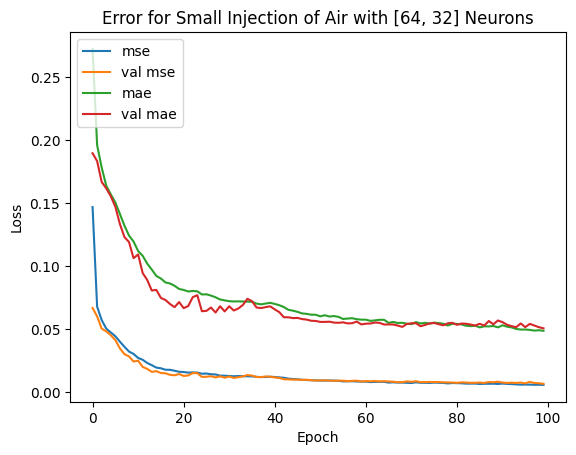

In [735]:
# plotting loss during training
plt.plot(out.history['loss'], label = "mse")
plt.plot(out.history['val_loss'], label= "val mse")
plt.plot(out.history['mae'], label = "mae")
plt.plot(out.history['val_mae'], label= "val mae")
plt.title(f"Error for {filepaths[filepath]} with {neurons} Neurons")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( loc = 'upper left')
plt.savefig(f"{filepaths[filepath]} {neurons}")
plt.show()


In [736]:
print(out.history["loss"][-1])

0.005713928956538439


In [737]:
# reshaping for testing data 
TestXreshape = TestX.reshape((TestX.shape[0], 1, TestX.shape[1], TestX.shape[2]))

In [738]:
# predicting outputs for test data
Y_pred_normalized = my_model.predict(TestXreshape)


# unscaling Y values
Y_pred_reshape = Y_pred_normalized.reshape(-1, npredfeatures)
Y_pred = scalerY.inverse_transform(Y_pred_reshape)

Y_pred = Y_pred.reshape(Y_pred_normalized.shape)



Y_pred.shape

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(1271, 35, 7)

In [739]:
from sklearn.metrics import mean_squared_error

test_mse = mean_squared_error(TestY.flatten(),Y_pred_normalized.flatten() )

print(f"Testing Mean Squared Error For {filepaths[filepath]} with {neurons} neurons: {test_mse}")

Testing Mean Squared Error For Small Injection of Air with [64, 32] neurons: 0.005181517162140377


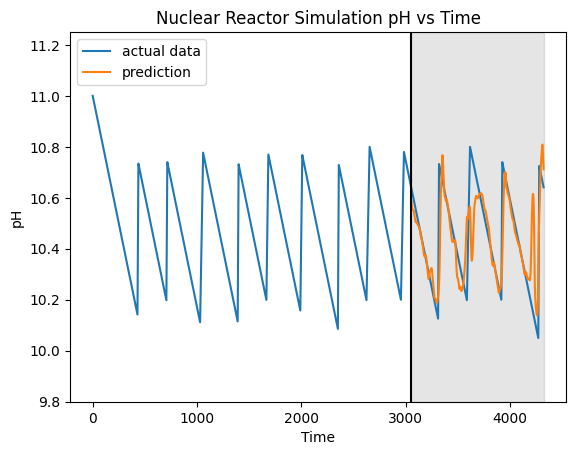

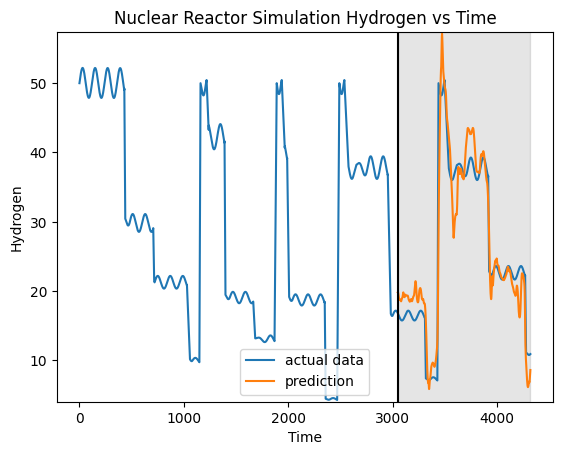

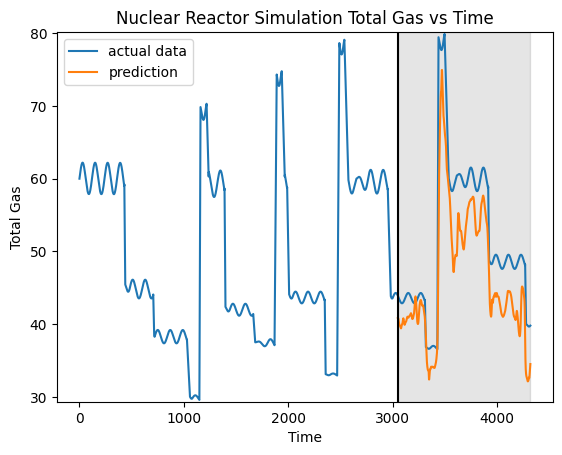

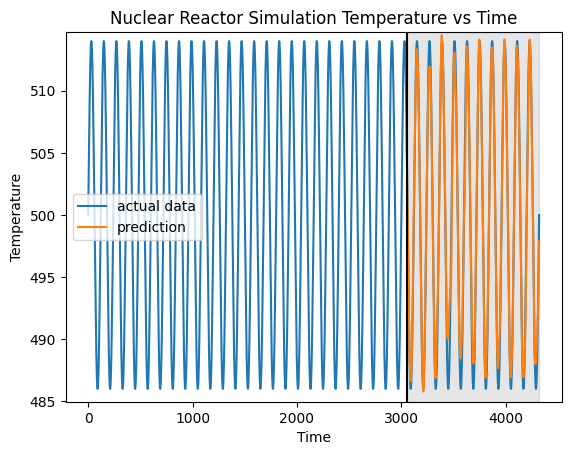

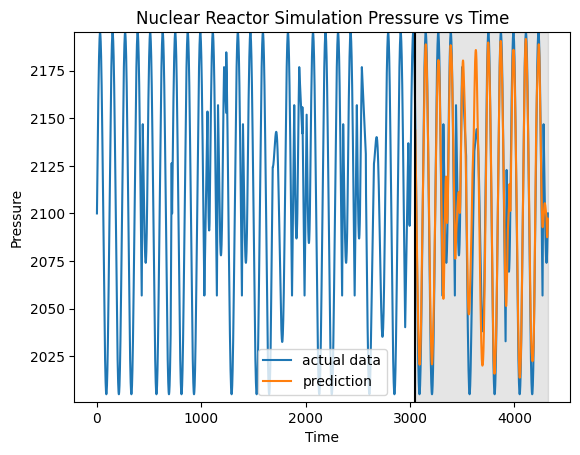

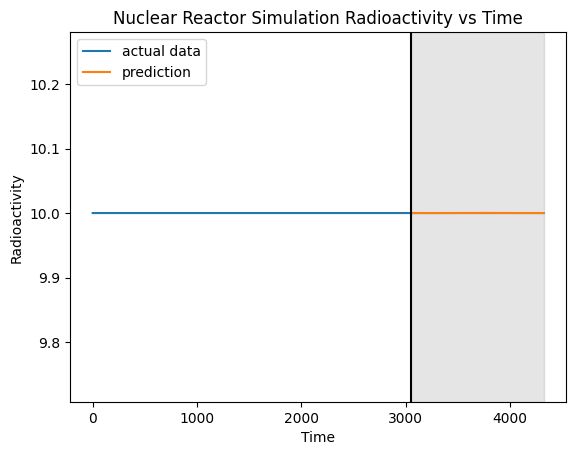

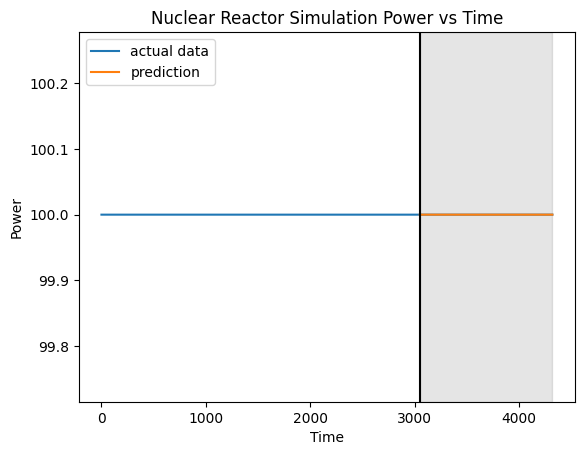

In [740]:

target_params = ["pH", 'Hydrogen', 'Total Gas', 'Temperature', 'Pressure', 'Radioactivity', 'Power']
t = data["Time"].values
t = t.reshape(len(t), 1)



for i, target_param in enumerate(target_params):

    # y(t) is the value of the target parameter at time t
    y_t = data[target_param].values
    y_t = y_t.reshape(len(y_t), 1)


    # predicted data
    back = Y_pred.shape[0]
    Y_predfeat = Y_pred[:, :, i]

    # setting bounds for graph
    y_min = min(np.min(Y_predfeat), np.min(y_t)) 
    y_max = max(np.max(Y_predfeat), np.max(y_t))
    plt.ylim(y_min - 0.25, y_max + 0.25)

    # plot
    plt.plot(t, y_t)
    plt.plot(t[-back:], Y_predfeat[:, nfuture_timesteps-1])
    plt.legend(['actual data', 'prediction'])
    plt.fill_between([t[-back,0], t[-1,0]], y_min-0.25, y_max+0.25 , color = 'k', alpha = 0.1)
    plt.plot([t[-back,0], t[-back,0]], [y_min-0.25, y_max+0.25 ], 'k-')
    plt.xlabel("Time")
    plt.ylabel(f"{target_param}")
    plt.title(f"Nuclear Reactor Simulation {target_param} vs Time")
    plt.show()

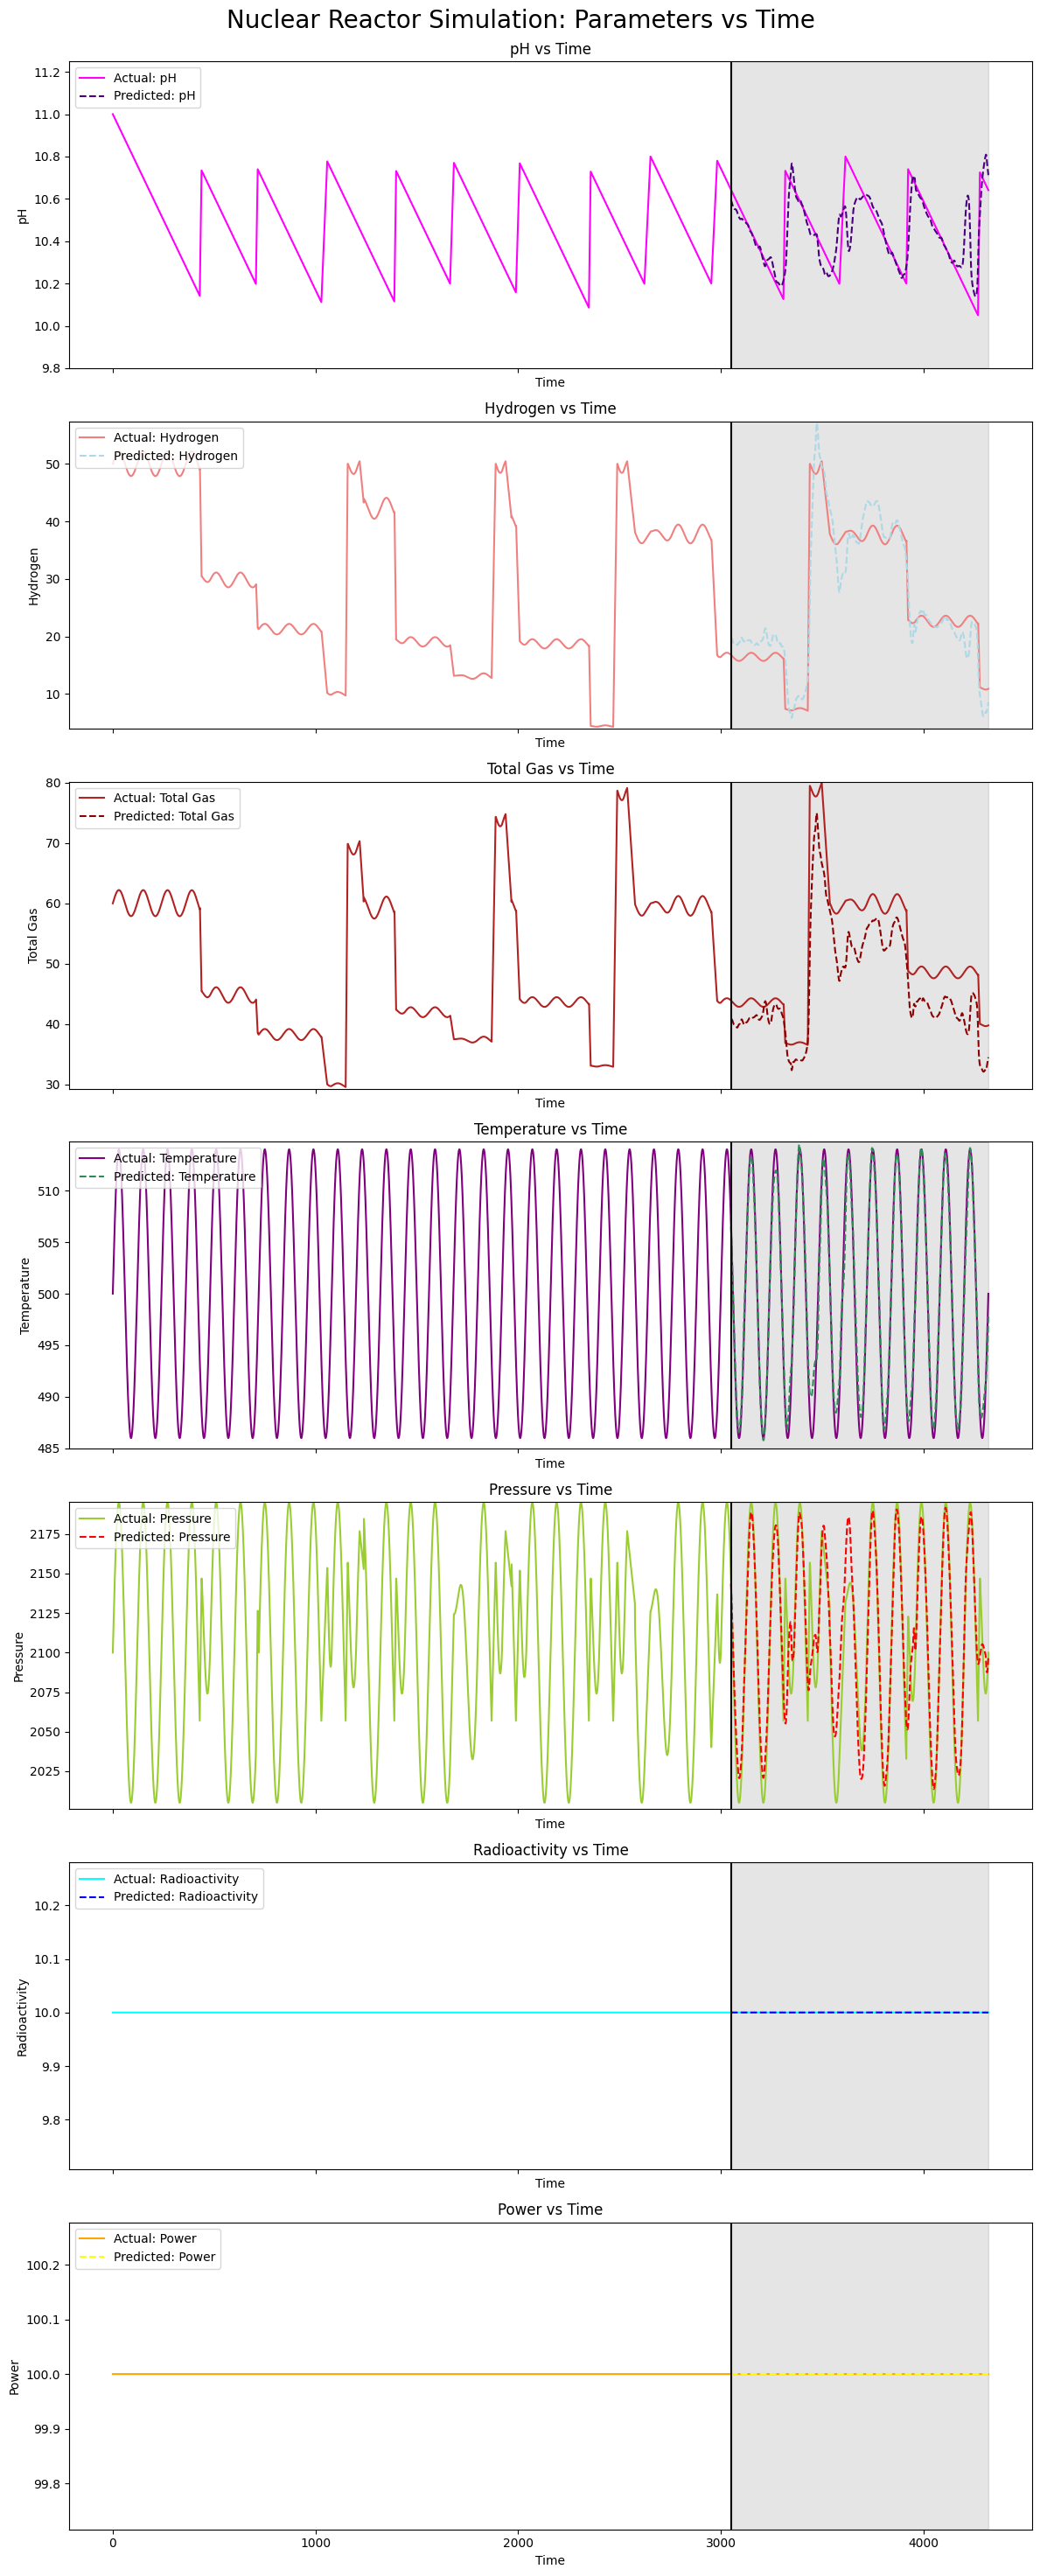

In [741]:
import matplotlib.pyplot as plt
import numpy as np

# Define target parameters and colors (7 colors for 7 parameters)
target_params = ["pH", 'Hydrogen', 'Total Gas', 'Temperature', 'Pressure', 'Radioactivity', 'Power']
color = ["magenta", "lightcoral", "firebrick", 
         "purple", "yellowgreen", "cyan", "orange"]  # Only 7 colors for 7 target parameters
color_2 = ["indigo", "lightblue",
         "darkred", "seagreen", "red", "blue", "yellow"]

# Reshape Time for plotting (ensure it's 1D for plotting)
t = data["Time"].values  # Original time values
t = t.flatten()  # Convert to 1D array

# Create a figure with subplots (one for each target parameter)
fig, axes = plt.subplots(len(target_params), 1, figsize=(12, 30), sharex=True)
fig.suptitle("Nuclear Reactor Simulation: Parameters vs Time", fontsize=20)

# Loop through each target parameter and create its subplot
for i, target_param in enumerate(target_params):
    ax = axes[i]  # Get the corresponding axis for the subplot

    # Actual data for each target parameter
    y_t = data[target_param].values
    y_t = y_t.flatten()  # Ensure y_t is 1D

    # Predicted data
    back = Y_pred.shape[0]
    Y_predfeat = Y_pred[:, :, i]


    # Setting bounds
    y_min = min(np.min(Y_predfeat), np.min(y_t)) 
    y_max = max(np.max(Y_predfeat), np.max(y_t))
    ax.set_ylim(y_min - 0.25, y_max + 0.25)

    # Plot data
    ax.plot(t, y_t, label=f"Actual: {target_param}", color=color[i])
    ax.plot(t[-back:], Y_predfeat[:, nfuture_timesteps-1], label=f"Predicted: {target_param}", linestyle='--', color=color_2[i])
    ax.fill_between(t[-back:], y_min-0.25, y_max+0.25, color='k', alpha=0.1)
    ax.plot([t[-back], t[-back]], [y_min-0.25, y_max+0.25], 'k-')
    ax.set_xlabel("Time")
    ax.set_ylabel(f"{target_param}")
    ax.set_title(f"{target_param} vs Time")
    
    # Add a legend to each subplot
    ax.legend(loc='upper left')

# Adjust layout to prevent overlap and add spacing for titles/labels
plt.tight_layout()
plt.subplots_adjust(top=0.96)

# Show the final plot
plt.show()
